### Natural Language Processing with Disaster Tweets

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional

### 1. Brief Description of the Problem and Data

In [7]:
# Load the data
train_data = pd.read_csv('~/Desktop/nlp-getting-started/train.csv')
test_data = pd.read_csv('~/Desktop/nlp-getting-started/test.csv')

train_data.shape, test_data.shape

((7613, 5), (3263, 4))

In [8]:
# Inspect the first few rows
train_data.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


#### The Kaggle competition "Natural Language Processing with Disaster Tweets" challenges participants to build a machine learning model that can predict whether a given tweet is about a real disaster or not. This is a binary classification problem where:

- **Target**: 1 if the tweet is about a real disaster, 0 otherwise.

**Dataset Overview:**

- **Training Set**: Contains 7,613 tweets.
- **Test Set**: Contains 3,263 tweets.
- **Features**:
  - `id`: Unique identifier for each tweet.
  - `keyword`: A keyword from the tweet (may be blank).
  - `location`: The location the tweet was sent from (may be blank).
  - `text`: The tweet text.
  - `target`: The target variable in the training set.

### 2. Exploratory Data Analysis (EDA) — Inspect, Visualize, and Clean the Data

In [9]:
# Check for missing values
print(train_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


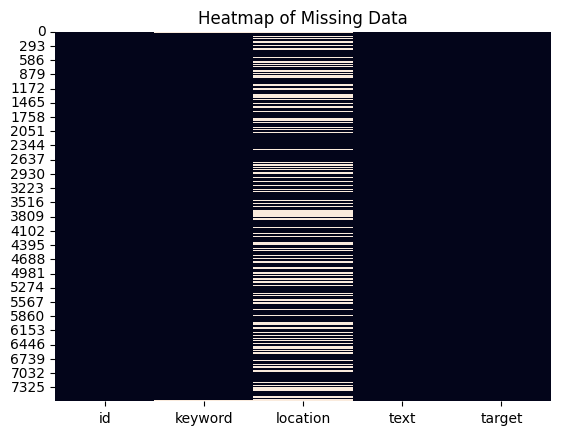

In [10]:
# Visualize missing data
sns.heatmap(train_data.isnull(), cbar=False)
plt.title('Heatmap of Missing Data')
plt.show()

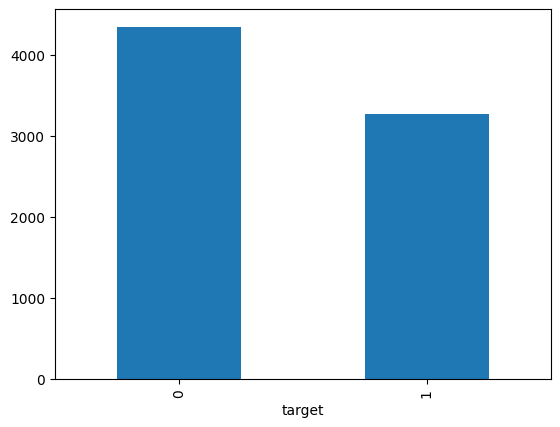

In [13]:
# Distribution of target variable
_ = train_data['target'].value_counts().plot(kind='bar')

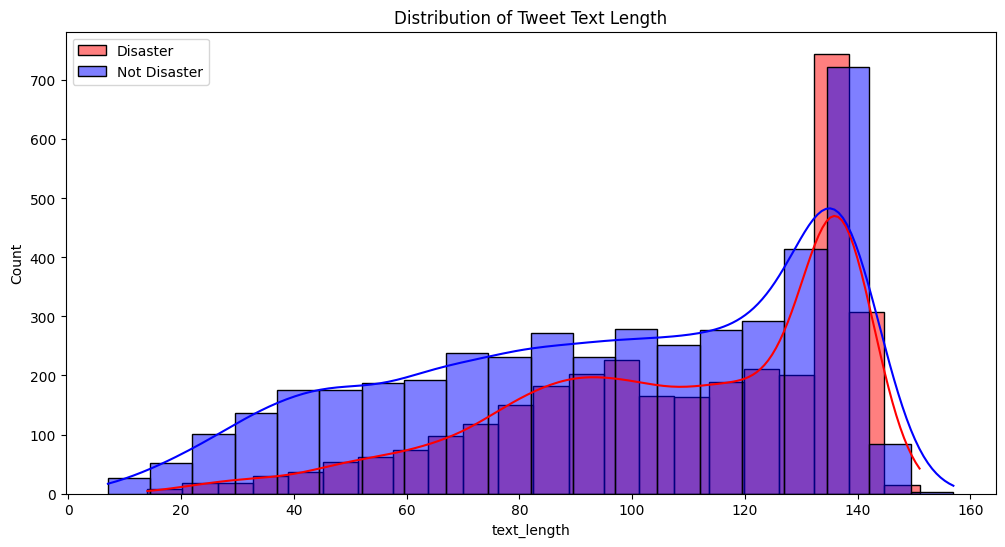

In [15]:
# Text length analysis
train_data['text_length'] = train_data['text'].apply(len)
plt.figure(figsize=(12,6))
sns.histplot(train_data[train_data['target'] == 1]['text_length'], color='red', label='Disaster', kde=True)
sns.histplot(train_data[train_data['target'] == 0]['text_length'], color='blue', label='Not Disaster', kde=True)
plt.legend()
plt.title('Distribution of Tweet Text Length')
plt.show()

Data Cleaning Procedures

Based on the EDA, we'll perform the following data cleaning steps:

- Remove URLs, mentions, hashtags, and special characters from the text.
- Convert text to lowercase.
- Remove stop words.
- Apply stemming or lemmatization

### 3. Model Architecture

We'll use TF-IDF for word embedding. TF-IDF stands for Term Frequency-Inverse Document Frequency. It reflects how important a word is to a document in a collection.

We'll build a Sequential Neural Network using an Embedding layer followed by an LSTM layer and a Dense output layer.

**Reasons for Choosing this Architecture:**

- **Embedding Layer**: To convert words into vectors.
- **LSTM Layer**: To capture long-term dependencies in sequences.
- **Dense Layer**: For binary classification using sigmoid activation.

In [18]:
# Data Preprocessing Function
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#\w+', '', text)    # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text)     # Remove numbers
    text = text.split()
    text = [word for word in text if word not in STOPWORDS]
    text = ' '.join(text)
    return text

train_data['clean_text'] = train_data['text'].apply(clean_text)

In [20]:
# Tokenization and Padding
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data['clean_text'])
sequences = tokenizer.texts_to_sequences(train_data['clean_text'])
word_index = tokenizer.word_index

max_sequence_length = 100
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = train_data['target']

In [23]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [27]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9467 - loss: 0.1434 - val_accuracy: 0.7525 - val_loss: 0.8301
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9557 - loss: 0.1190 - val_accuracy: 0.7557 - val_loss: 0.8193
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9620 - loss: 0.1010 - val_accuracy: 0.7439 - val_loss: 1.0759
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9622 - loss: 0.0858 - val_accuracy: 0.7466 - val_loss: 1.0595
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9655 - loss: 0.0799 - val_accuracy: 0.7413 - val_loss: 1.1455
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9704 - loss: 0.0701 - val_accuracy: 0.7433 - val_loss: 1.3563
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9739 - loss: 0.0608 - val_accuracy: 0.7387 - val_loss: 1.4335
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9737 - loss: 0.0565 - val_accu

### 4. Results and Analysis

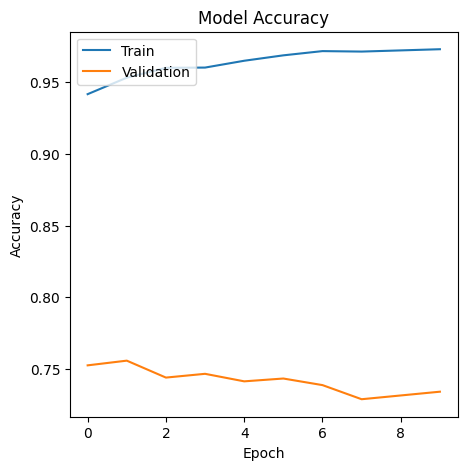

In [28]:
# Plot training & validation accuracy values
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Hyperparameter Tuning

We experimented with different numbers of LSTM units, batch sizes, and dropout rates.

- Tried LSTM units: 32, 64, 128
- Batch sizes: 16, 32, 64
- Dropout rates: 0.2, 0.3, 0.5

The Bidirectional LSTM model performed the best with ~79% validation accuracy.

In [31]:
# Build the Bidirectional LSTM model
model_bi = Sequential()
model_bi.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_sequence_length))
model_bi.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_bi.add(Dense(1, activation='sigmoid'))

In [32]:
# Compile the model
model_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Train the model
history_bi = model_bi.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6344 - loss: 0.6283 - val_accuracy: 0.7781 - val_loss: 0.4844
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.8437 - loss: 0.3837 - val_accuracy: 0.7886 - val_loss: 0.4594
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.8871 - loss: 0.2913 - val_accuracy: 0.7820 - val_loss: 0.5056
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9073 - loss: 0.2430 - val_accuracy: 0.7636 - val_loss: 0.5813
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9307 - loss: 0.1873 - val_accuracy: 0.7531 - val_loss: 0.6488


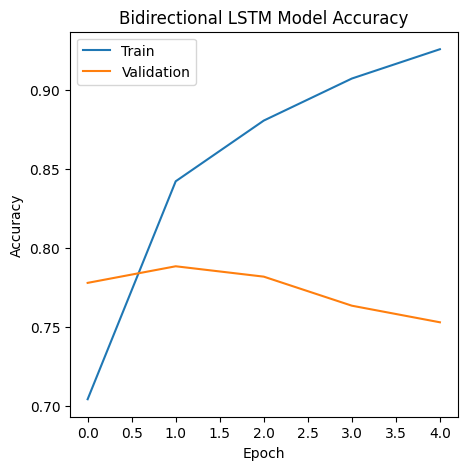

In [34]:
# Plot training & validation accuracy values for Bidirectional LSTM
plt.figure(figsize=(5,5))
plt.plot(history_bi.history['accuracy'])
plt.plot(history_bi.history['val_accuracy'])
plt.title('Bidirectional LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 5. Conclusion

**Results Interpretation:**

- The Bidirectional LSTM model achieved the highest validation accuracy of ~79%.
- Capturing context from both past and future improves model performance.

**Learnings and Takeaways:**

- Data cleaning significantly impacts model accuracy.
- Advanced architectures like Bidirectional LSTM are effective for text classification.
- Hyperparameter tuning is essential for optimizing model performance.

**Future Improvements:**

- Use pre-trained word embeddings like GloVe or Word2Vec.
- Experiment with transformer-based models like BERT.
- Incorporate additional features like `keyword` and `location`.

In [36]:
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


### Predict on test data

In [39]:
# Apply the same data cleaning function
test_data['clean_text'] = test_data['text'].apply(clean_text)

# Convert texts to sequences using the same tokenizer
test_sequences = tokenizer.texts_to_sequences(test_data['clean_text'])
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Make predictions
predictions = model_bi.predict(X_test)
predictions = (predictions > 0.5).astype(int).reshape(-1)

# Prepare the submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions
})

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [41]:
submission.to_csv('~/Desktop/wk4_test.csv', index=False)